<a href="https://colab.research.google.com/github/dianaventura/My-Honours-Project/blob/main/DISS_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error
import numpy as np



from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM


!pip install keras-tuner --upgrade

import keras_tuner

Data Exploration :)


In [ ]:

file_path = 'node-data-1.csv'

node_data_df = pd.read_csv(file_path)


print("First few rows of the dataset:")
print(node_data_df.head())

# display the dimensions of the dataset
print("\nDimensions of the dataset:")
print(node_data_df.shape)

# display column names
print("\nColumn names!!!:")
print(node_data_df.columns)

# display data types of each column
print("\nData types of each column:")
print(node_data_df.dtypes)

row_first = node_data_df.iloc[0]
print(row_first)

First few rows of the dataset:
               Node          Time  \
0  r7217787-n911952  1.614557e+09   
1  r4858666-n911952  1.614557e+09   
2  r2582019-n911952  1.614557e+09   
3  r9040233-n911952  1.614557e+09   
4  r4229531-n911952  1.614557e+09   

                                        UserPIDCount  FSlatency  LoadAvg  \
0  91472915699408:11|1706828023724:15|65855960046...        0.0    29.24   
1                                 66720169194922:40|        0.0     4.07   
2                                 22654259079669:47|        0.0    40.01   
3  91472915699408:7|12886809117418:29|53679664603...        0.0    29.58   
4                                  15914930715133:5|        0.0     0.26   

   MemoryFreeInactiveKB  LustreRPCTotals  
0                 371.0          26359.0  
1                 363.0            228.0  
2                 377.0           2006.0  
3                 369.0           8289.0  
4                 390.0            227.0  

Dimensions of the dataset:
(57

Understanding What Each Collum Means
Node: the node ID within thhe cluster

Timestamps in UNIX format(how many seconds past since january 1974?)

UserPIDCount respresents number of processes running per user per node.

FSLatency mteric for understanding how quickly system can access or write to the file system.

Load Avg metric represents number of processes waiting for CPU time.

MemoryFreeInactiveKB amount of inactive memory in kilobytes

LustreRPCTotals number of calls to the file system. Lustre acts like an auto bookshelf moving things around for effiency storage access.

In [ ]:
#number of unique nodes
unique_nodes = node_data_df['Node'].nunique()
print("Number of unique nodes: ")
print(unique_nodes)

Number of unique nodes: 
731


In [ ]:
#checking for missing values

missing_values = node_data_df.isnull().sum()
print("Missing Values in each column: ")
print(missing_values)

Missing Values in each column: 
Node                         0
Time                         0
UserPIDCount            767954
FSlatency                    0
LoadAvg                      0
MemoryFreeInactiveKB         0
LustreRPCTotals              0
dtype: int64


In [ ]:
# converting from unix to datetime

node_data_df['DateTime'] = pd.to_datetime(node_data_df['Time'],unit='s')

time_range = node_data_df['DateTime'].agg([min,max])
print(time_range)



min   2020-07-29 12:25:01
max   2021-04-12 08:35:03
Name: DateTime, dtype: datetime64[ns]


Text(0, 0.5, 'Average')

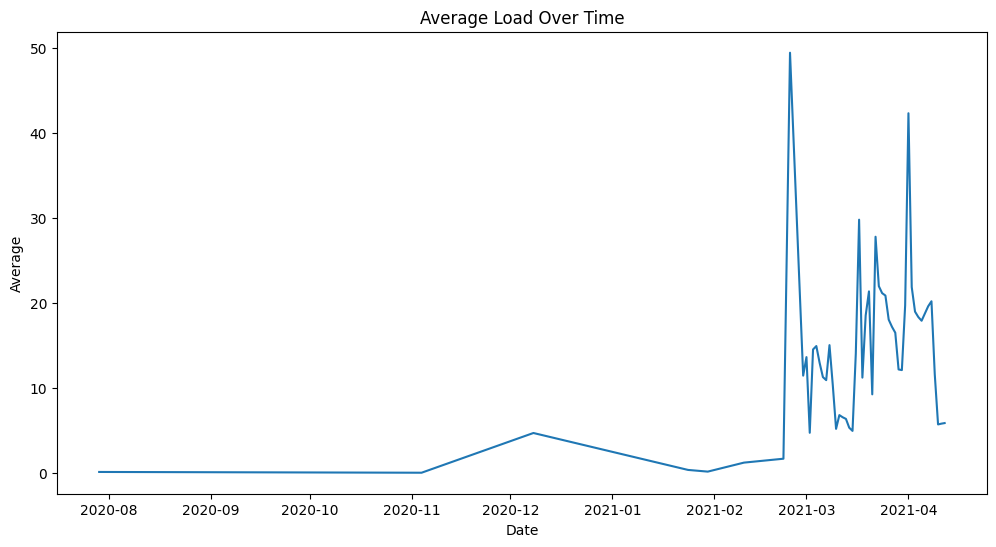

In [ ]:
#Load Average over Time

node_data_df.groupby(node_data_df['DateTime'].dt.date)['LoadAvg'].mean().plot(kind='line')

plt.gcf().set_size_inches(12, 6)

plt.title('Average Load Over Time')
plt.xlabel('Date')

plt.ylabel('Average')

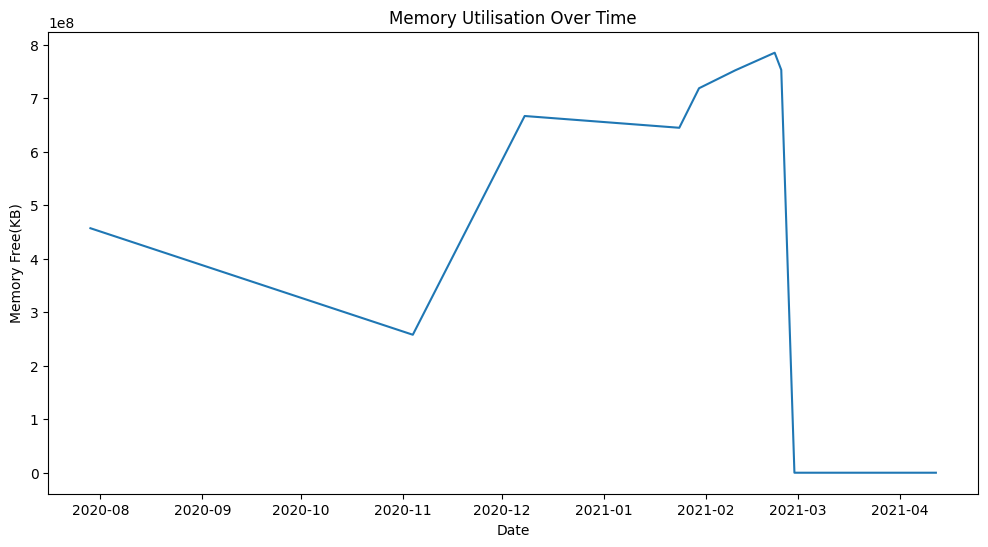

In [ ]:
#Memory usage over Time

node_data_df.groupby(node_data_df['DateTime'].dt.date)['MemoryFreeInactiveKB'].mean().plot(kind='line')

plt.gcf().set_size_inches(12, 6)

plt.title('Memory Utilisation Over Time')
plt.xlabel('Date')

plt.ylabel('Memory Free(KB)')
plt.show()

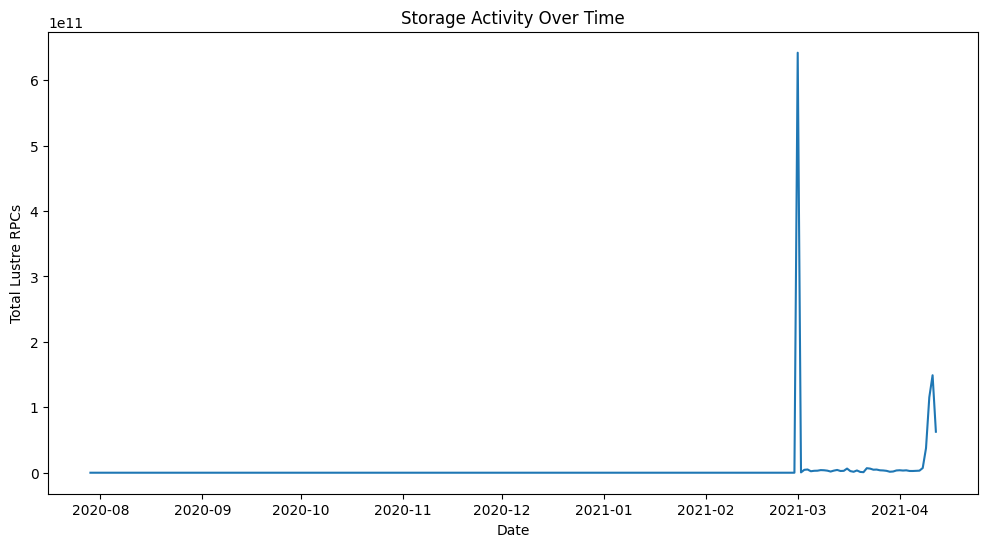

In [ ]:
#Storage Activity over Time

node_data_df.groupby(node_data_df['DateTime'].dt.date)['LustreRPCTotals'].sum().plot(kind='line')

plt.gcf().set_size_inches(12, 6)

plt.title('Storage Activity Over Time')
plt.xlabel('Date')

plt.ylabel('Total Lustre RPCs')
plt.show()

#this seems wrong why zero for first half of data - suspicious explore further.

In [ ]:
#feature enginerring :0

In [ ]:
#load average to memory usage ratio

#this metric could highlight places where resources may be under or over used, could offer a clear target for optimisations.
#high ratio means lots of data processinf efficiently
#low ratio means not that much data being processed but this node has the capacity to do more

node_data_df['LM-Ratio'] = node_data_df['LoadAvg']/node_data_df['MemoryFreeInactiveKB']

#print(node_data_df.head())

In [ ]:
#average of LM Ratio

average_lm_ratio = node_data_df['LM-Ratio'].mean()

print(average_lm_ratio)

0.40273580040297474


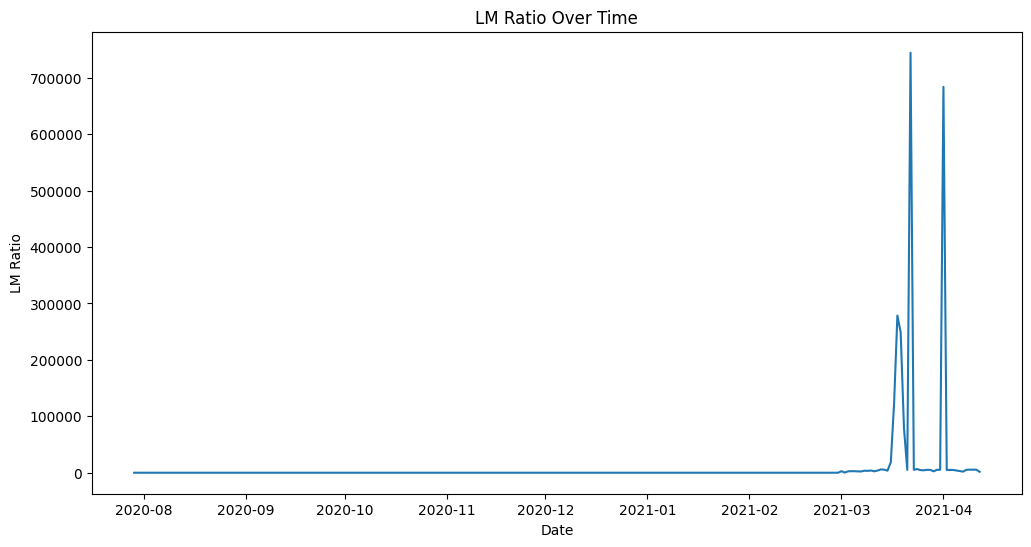

In [ ]:
node_data_df.groupby(node_data_df['DateTime'].dt.date)['LM-Ratio'].sum().plot(kind='line')

plt.gcf().set_size_inches(12, 6)

plt.title('LM Ratio Over Time')
plt.xlabel('Date')

plt.ylabel('LM Ratio')
plt.show()


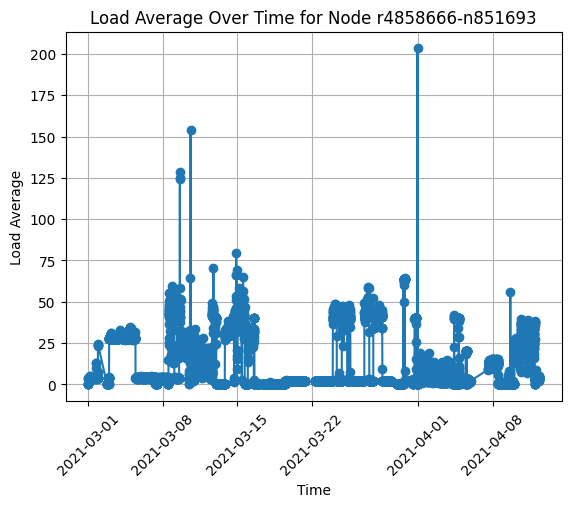

In [ ]:
# we want this node bc its in the top ten
node_A = 'r4858666-n851693'

node_to_plot = node_data_df[node_data_df['Node'] == node_A]

# Filter the dataset for the selected node
node_specific_df = node_data_df[node_data_df['Node'] == node_A]

# Plotting
#plt.figure(figsize=(10, 6))
plt.plot(node_specific_df['DateTime'], node_specific_df['LoadAvg'], marker='o', linestyle='-')
plt.title(f'Load Average Over Time for Node {node_A}')
plt.xlabel('Time')
plt.ylabel('Load Average')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Print the shape of the dataset
print(node_data_df.shape)

# Get the summary information including data types and number of non-null values
print(node_data_df.info())

# Get statistical summaries of the numerical columns
print(node_data_df.describe())

# Print the first few rows of the dataframe to see actual data samples
print(node_data_df.head())


(5775984, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5775984 entries, 0 to 5775983
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Node                  object        
 1   Time                  float64       
 2   UserPIDCount          object        
 3   FSlatency             float64       
 4   LoadAvg               float64       
 5   MemoryFreeInactiveKB  float64       
 6   LustreRPCTotals       float64       
 7   DateTime              datetime64[ns]
 8   LM-Ratio              float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 396.6+ MB
None
               Time  FSlatency       LoadAvg  MemoryFreeInactiveKB  \
count  5.775984e+06  5775984.0  5.775984e+06          5.775984e+06   
mean   1.616475e+09        0.0  1.957264e+01          9.343548e+05   
min    1.596026e+09        0.0  0.000000e+00          0.000000e+00   
25%    1.615795e+09        0.0  0.000000e+00          4

In [ ]:
#UserPIDCount Analysis
#13% of this collum is missing values significant but not huge

#figuring out if missing values correlate with other variables

node_data_df['missing?'] = node_data_df['UserPIDCount'].isnull().astype(int)



In [ ]:
unique_node_ids_count = node_data_df['Node'].nunique()


print(f'There are {unique_node_ids_count} unique node IDs.')

There are 731 unique node IDs.


In [ ]:
#average timestamps per unique node

avg_per_node = node_data_df.shape[0] / unique_nodes
print("Average data points per node: " )
print(avg_per_node)

Average data points per node: 
7901.482900136799


In [ ]:
# the number of timestamps for the selected node
num_timestamps = node_specific_df.shape[0]


print(f'Number of timestamps associated with Node {node_to_plot}: {num_timestamps}')


Number of timestamps associated with Node                      Node          Time            UserPIDCount  FSlatency  \
33       r4858666-n851693  1.614557e+09                     NaN        0.0   
284      r4858666-n851693  1.614557e+09                     NaN        0.0   
535      r4858666-n851693  1.614557e+09                     NaN        0.0   
786      r4858666-n851693  1.614558e+09                     NaN        0.0   
1037     r4858666-n851693  1.614558e+09                     NaN        0.0   
...                   ...           ...                     ...        ...   
5772589  r4858666-n851693  1.618215e+09  87256509282194:22|7:2|        0.0   
5773313  r4858666-n851693  1.618216e+09  87256509282194:22|7:2|        0.0   
5774037  r4858666-n851693  1.618216e+09  87256509282194:23|7:2|        0.0   
5774761  r4858666-n851693  1.618216e+09  87256509282194:22|7:2|        0.0   
5775485  r4858666-n851693  1.618217e+09  87256509282194:22|7:2|        0.0   

         LoadAvg  Mem

In [ ]:
#getting nodes with most datapoints
#count timestamps per node
ts_pernode = node_data_df.groupby('Node').size()
#sort them
sorted = ts_pernode.sort_values(ascending=False)
#print(sorted)

top_10_ids = sorted.head(10).index

#new dataframe from only nodes with most data
top_10 = node_data_df[node_data_df['Node'].isin(top_10_ids)]

#print(top_100.shape)
#print(top_100.head)
print(top_10['Node'].unique())




['r4858666-n851693' 'r9102715-n976057' 'r2652301-n976057'
 'r6760045-n976057' 'r4858666-n386398' 'r2582019-n386398'
 'r8642123-n386398' 'r2100214-n386398' 'r629115-n386398'
 'r9192091-n386398']


In [ ]:
#because of the way userpidcount is collected have to extract it or drop if not useful

Time                   -0.282692
LoadAvg                -0.241886
LM-Ratio               -0.158997
LustreRPCTotals        -0.005526
MemoryFreeInactiveKB    0.018102
missing?                1.000000
FSlatency                    NaN
Name: missing?, dtype: float64
(5008030, 10)


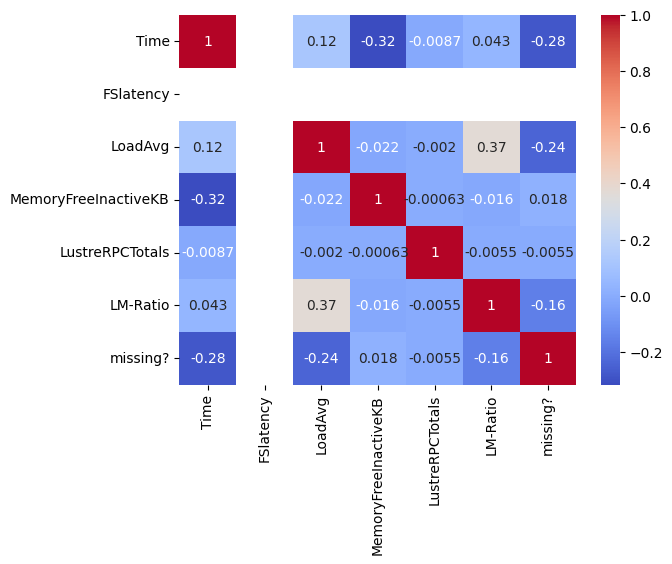

In [ ]:
#important to remember that top nodes refers to the nodes with most datapoints not the ones using the most energy.

#for heatmap we only care about numeric vals
numeric_cols_only = node_data_df.select_dtypes(include=[np.number])

correlations = numeric_cols_only.corr()

sns.heatmap(correlations,annot=True,cmap='coolwarm')

print(correlations['missing?'].sort_values())
#heatmap shows
#seemingly has weak correlations with other variables so can assume missing values are at random

#because random they are not likely to bias the data so can exclude these values for analysis

#dropping rows with missing UserPIDCount

clean_nodes = node_data_df.dropna(subset=['UserPIDCount'])

print(clean_nodes.shape)



##Seasonality

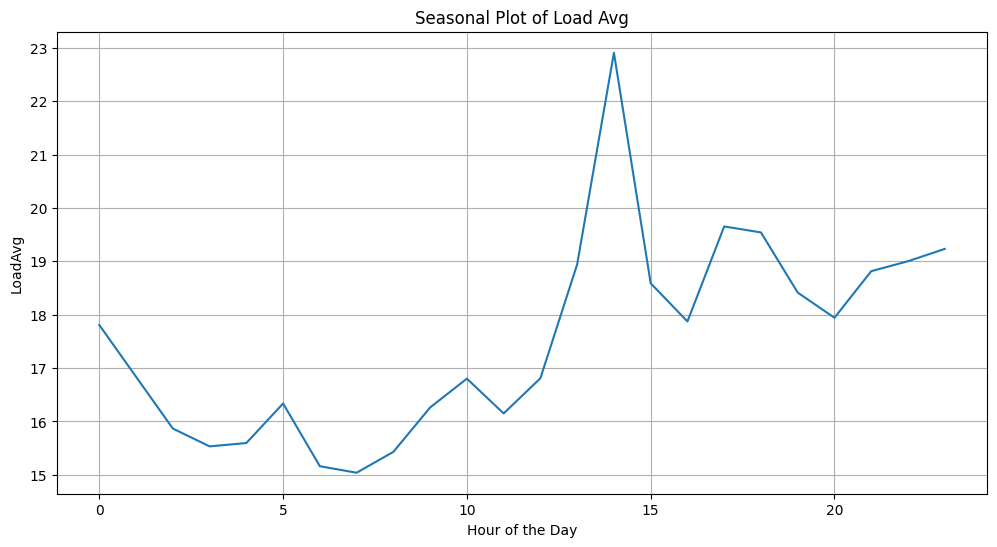

In [ ]:
import matplotlib.pyplot as plt


data_seasons = top_10.copy()


data_seasons.set_index('DateTime', inplace=True)


seasonal_data_load = data_seasons.groupby(data_seasons.index.hour)['LoadAvg'].mean()

# plotting the seasonality
plt.figure(figsize=(12, 6))
seasonal_data_load.plot()
plt.title('Seasonal Plot of Load Avg' )
plt.xlabel('Hour of the Day')
plt.ylabel('LoadAvg')
plt.grid(True)
plt.show()


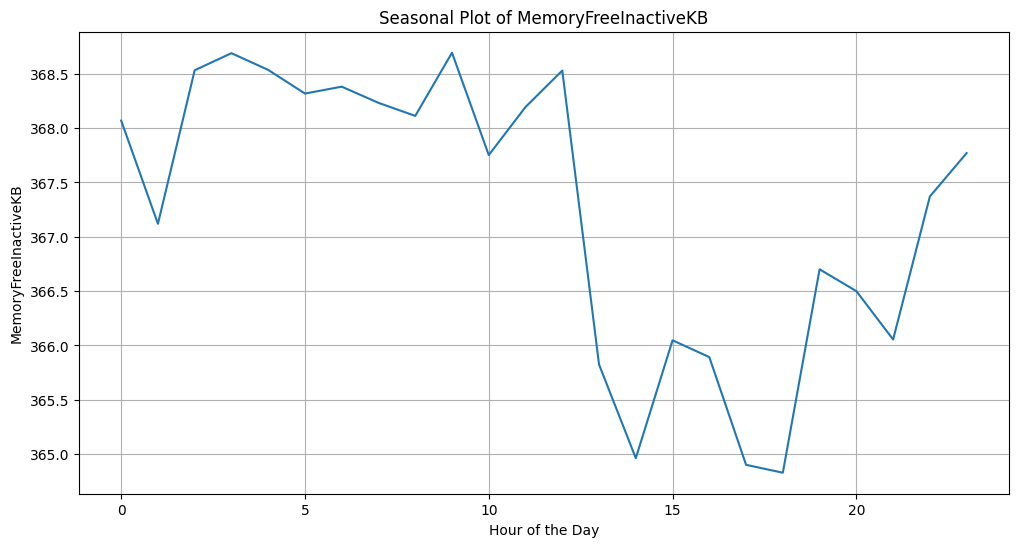

In [ ]:
import matplotlib.pyplot as plt


mem_seasonal_data = data_seasons.groupby(data_seasons.index.hour)['MemoryFreeInactiveKB'].mean()

# Plotting the seasonality
plt.figure(figsize=(12, 6))
mem_seasonal_data.plot()
plt.title('Seasonal Plot of MemoryFreeInactiveKB')
plt.xlabel('Hour of the Day')
plt.ylabel('MemoryFreeInactiveKB')
plt.grid(True)
plt.show()


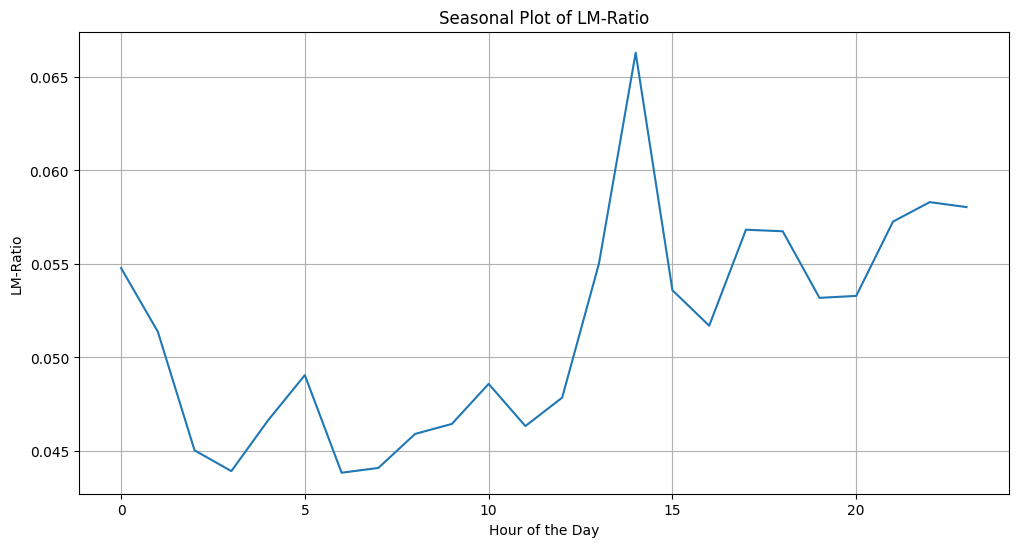

In [ ]:
import matplotlib.pyplot as plt


lm_seasonal_data = data_seasons.groupby(data_seasons.index.hour)['LM-Ratio'].mean()

# Plotting the seasonality
plt.figure(figsize=(12, 6))
lm_seasonal_data.plot()
plt.title('Seasonal Plot of LM-Ratio' )
plt.xlabel('Hour of the Day')
plt.ylabel('LM-Ratio')
plt.grid(True)
plt.show()


The trends below show that Load Avg and MemoryFreeInactive have different patterns. Load Average seems to be more stable with variablity in sudden peaks wheres MemoryFree stays high and slowly decreases over time.

What this means for my LSTM model is that we want a model to be able to predict accounting for the differences in pattern we will want to experiment with window size and sequence length to find out what best captures the nature of the data.

The output below solidifies the need for a stack LSTM architecture to capture complex patterns and also suggests that the model would benefit from some bidirectional layers to use previous and subsequent data points for prediction.

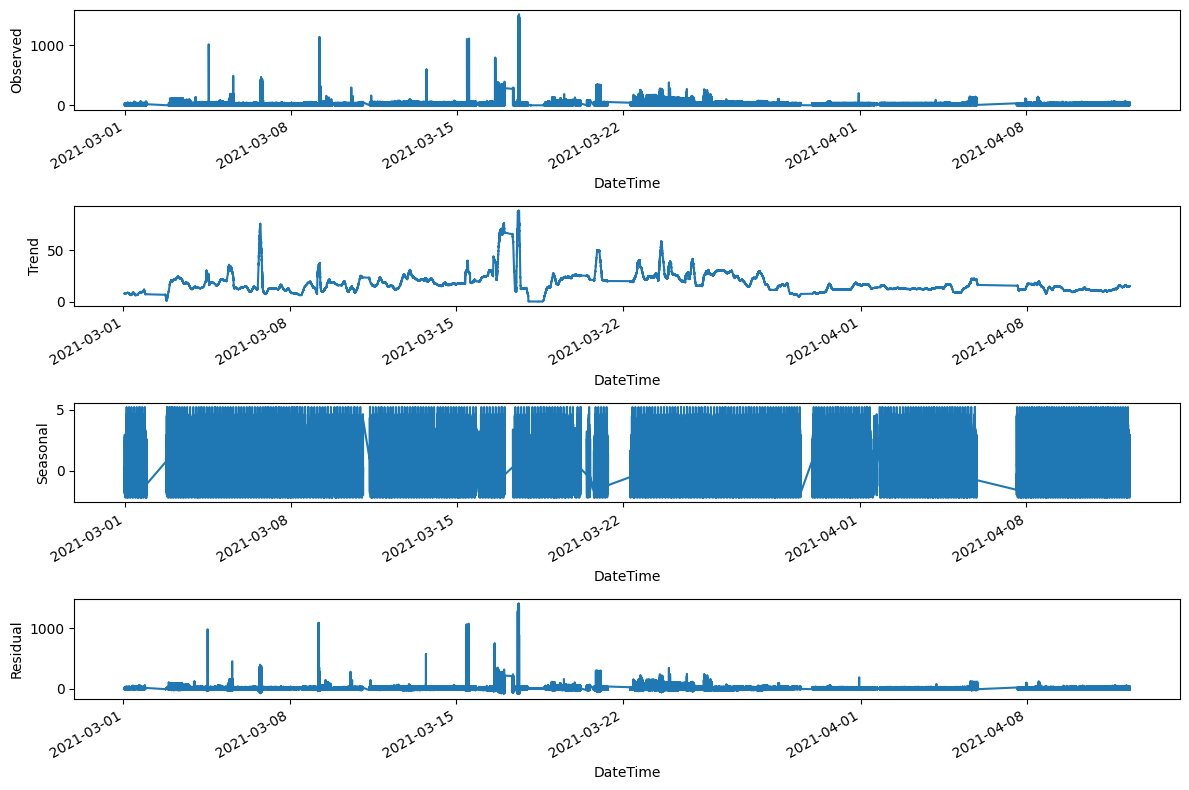

In [ ]:
#period here is 60/5 x 24
decomposition = sm.tsa.seasonal_decompose(data_seasons['LoadAvg'], model='additive', period=288)

# plot the decomposition

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

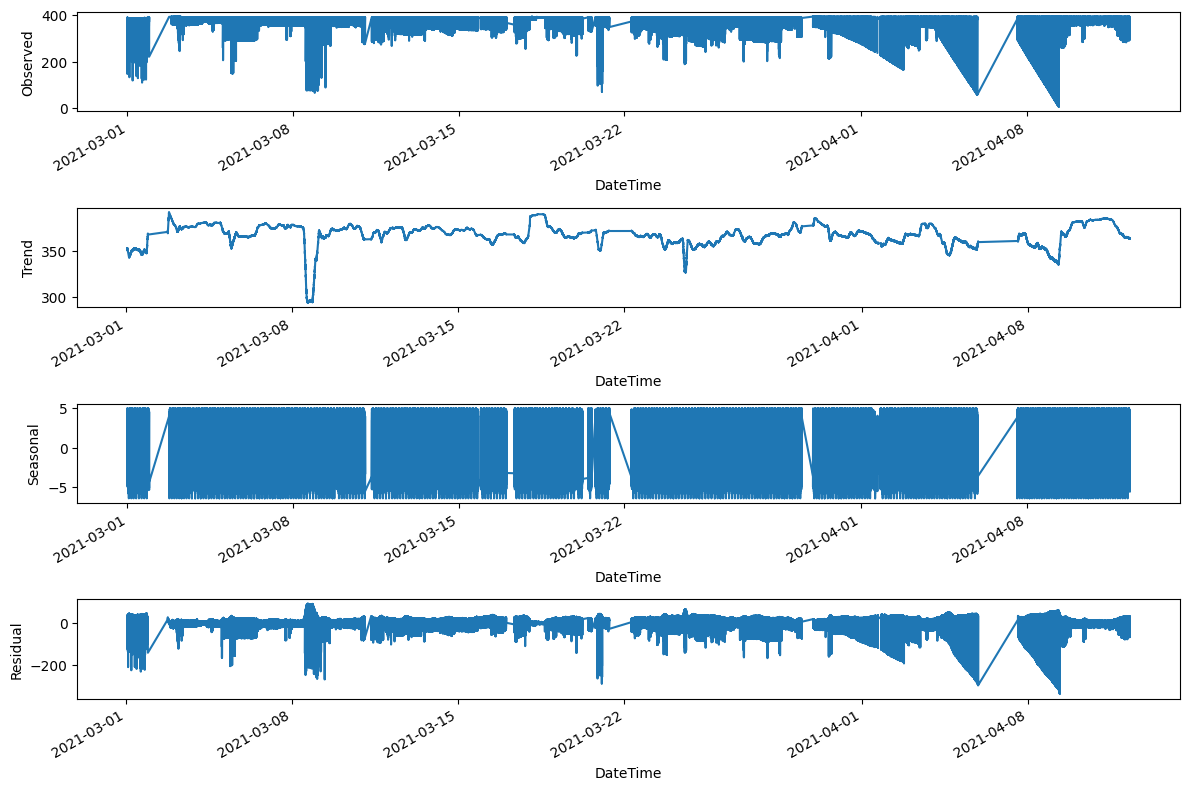

In [ ]:

decomposition = sm.tsa.seasonal_decompose(data_seasons['MemoryFreeInactiveKB'], model='additive', period=288)

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In the observed plot we can see all the data over time with significant variablity with low periods and also big spikes.


the objective of these models is to predict usage times and try capture peaks as accuractely as possible.

best choice model is LSTM.

Preparing Data

In [ ]:
#dataset with data for just one node

node_A_df = node_data_df[node_data_df['Node'] == node_A]

node_A_set = node_A_df[['Node','DateTime','LoadAvg','MemoryFreeInactiveKB','LM-Ratio','LustreRPCTotals']]

print(node_A_set.head(12))

                  Node            DateTime  LoadAvg  MemoryFreeInactiveKB  \
33    r4858666-n851693 2021-02-28 23:55:01     0.06                 388.0   
284   r4858666-n851693 2021-03-01 00:05:01     0.07                 388.0   
535   r4858666-n851693 2021-03-01 00:10:01     0.08                 388.0   
786   r4858666-n851693 2021-03-01 00:15:01     0.37                 388.0   
1037  r4858666-n851693 2021-03-01 00:20:01     0.05                 388.0   
1288  r4858666-n851693 2021-03-01 00:25:01     0.50                 388.0   
1539  r4858666-n851693 2021-03-01 00:30:01     3.59                 380.0   
1790  r4858666-n851693 2021-03-01 00:35:01     4.11                 381.0   
2041  r4858666-n851693 2021-03-01 00:40:01     3.99                 381.0   
2292  r4858666-n851693 2021-03-01 00:45:01     3.96                 381.0   
2543  r4858666-n851693 2021-03-01 00:50:01     4.10                 381.0   
2794  r4858666-n851693 2021-03-01 00:55:01     4.06                 381.0   

Granualarity of Data is Captured every 5 minutes

In [ ]:

# time differences between consecutive timestamps
time_diffs = node_A_set['DateTime'].diff()

# drop the first row as it will have NaT (Not a Time)
time_diffs = time_diffs.dropna()

# print the most common time interval (mode)
most_common_interval = time_diffs.mode().iloc[0]
print("Most common time interval:", most_common_interval)


Most common time interval: 0 days 00:05:00


                Node            DateTime  LoadAvg  MemoryFreeInactiveKB  \
33  r4858666-n851693 2021-02-28 23:55:01     0.06                 388.0   
86  r9102715-n976057 2021-03-01 00:00:01     0.01                 376.0   

    LM-Ratio  LustreRPCTotals  
33  0.000155            220.0  
86  0.000027          64642.0  
                             LoadAvg                                    \
Node                r2100214-n386398 r2582019-n386398 r2652301-n976057   
DateTime                                                                 
2021-02-28 23:55:01              NaN              NaN              NaN   

                                                                       \
Node                r4858666-n386398 r4858666-n851693 r629115-n386398   
DateTime                                                                
2021-02-28 23:55:01              NaN             0.06             NaN   

                                                                        \
Node          

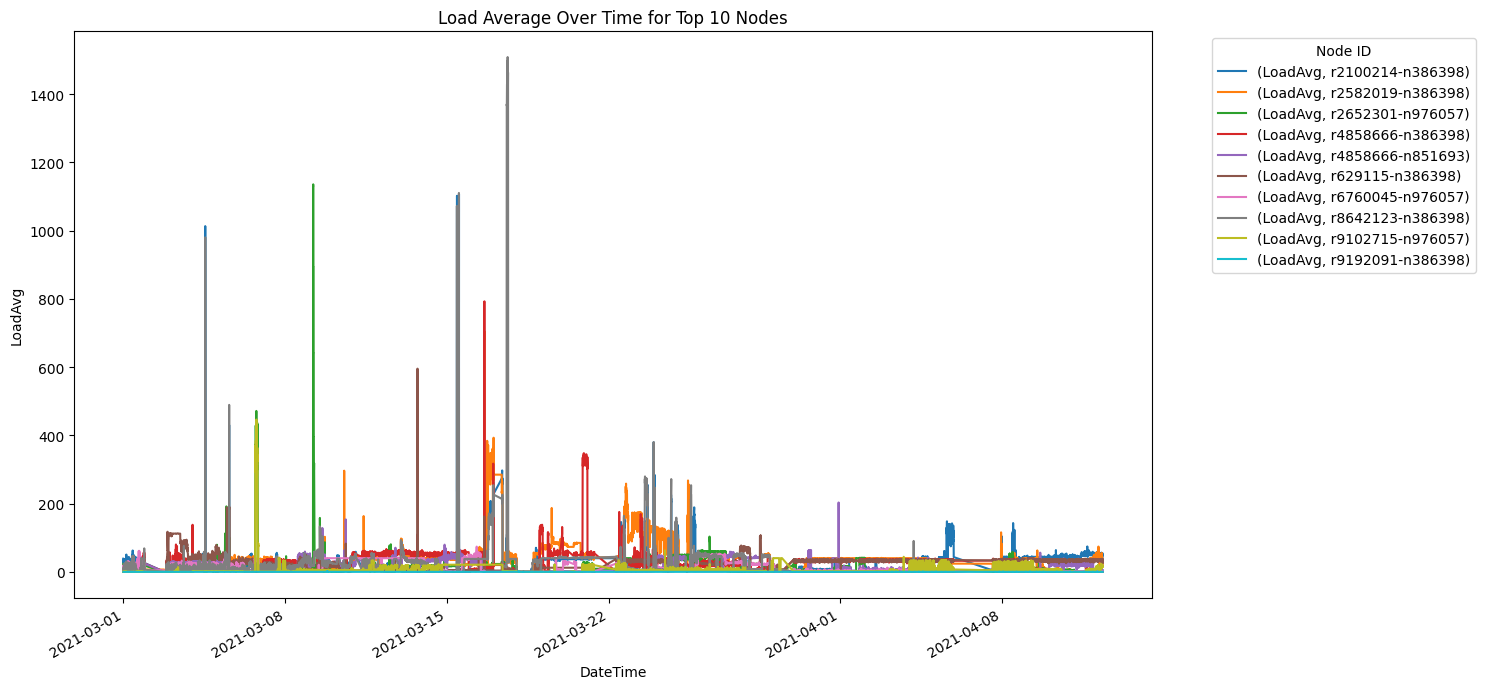

In [ ]:
#important to remember that top nodes refers to the nodes with most datapoints not the ones using the most energy.


top_10_nodes = top_10[['Node','DateTime','LoadAvg','MemoryFreeInactiveKB','LM-Ratio','LustreRPCTotals']]
print(top_10_nodes.head(2))


unique_node_ids = top_10['Node'].unique()
#print(unique_node_ids)

pivoted_data = top_10_nodes.pivot_table(
    index='DateTime',
    columns='Node',
    values=['LoadAvg'],
    aggfunc='mean'
)

print(pivoted_data.head(1))

print(pivoted_data.shape) #15712,10

#forward fill and backward fill for Nan values not every node has a datetimestamp for each stamp
cleaned_data = pivoted_data.fillna(method='ffill')
cleaned_data = cleaned_data.fillna(method='bfill')

print(cleaned_data.head())

print(cleaned_data.shape) #15712,10

print(cleaned_data.isna().sum()) #none

print(cleaned_data.columns)


# plots all columns over time
cleaned_data.plot(figsize=(15, 7))

plt.title('Load Average Over Time for Top 10 Nodes')
plt.xlabel('DateTime')
plt.ylabel('LoadAvg')
plt.legend(title='Node ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()



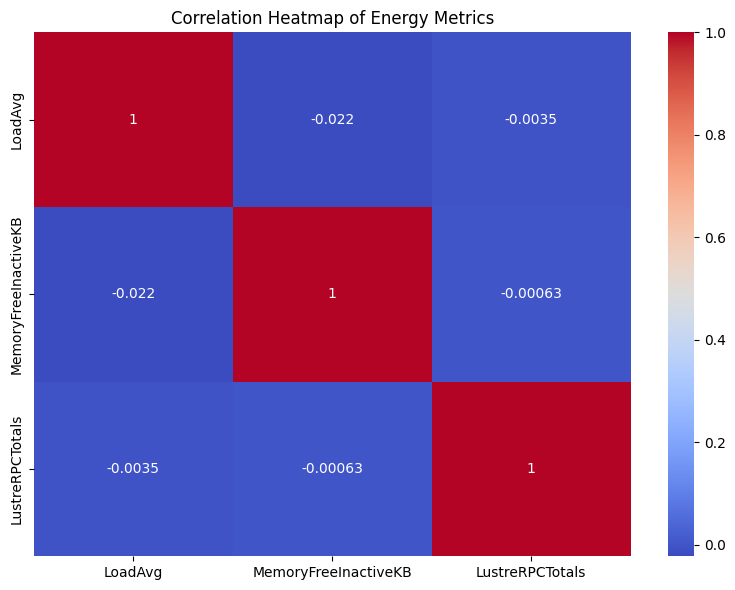

In [ ]:
energy_metrics_cols = ['LoadAvg','MemoryFreeInactiveKB','LM-Ratio','LustreRPCTotals']
energy_metrics_og = ['LoadAvg','MemoryFreeInactiveKB','LustreRPCTotals']
energy_corr = clean_nodes[energy_metrics_og].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(energy_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Energy Metrics')
plt.tight_layout()
plt.show()
#print(energy_corr)

#correlation matrix shows weak correlations suggesting that these metrics vary largely across individual nodes.
#most of the off-diagonal values are close to 0, suggesting very weak correlations between those pairs of metrics.
# indicating no meaningful linear relationship between them
#This is important because it means no one metric can reliably predict another.

Even though we want to just focus on Load Average the subset contains four energy metrics for future projects.

In [ ]:
#min-max scaling
#for scale whole set
uh_values = clean_nodes[energy_metrics_cols].values


#for scale top 10 nodes
top_10_values = top_10[energy_metrics_cols].values

uh_reshape = uh_values.reshape(-1,4)

n10_reshape = top_10_values.reshape(-1,4)

scaler = MinMaxScaler()

n10scaler = MinMaxScaler()

scaled = scaler.fit_transform(uh_reshape)
n10_scaled = n10scaler.fit_transform(n10_reshape)

scaled_df = pd.DataFrame(scaled, columns=energy_metrics_cols)
n10_df = pd.DataFrame(n10_scaled, columns=energy_metrics_cols)

print(scaled_df.shape)
print(n10_df.shape)

(5008030, 4)
(92597, 4)


In [ ]:
print(n10_df.index)

RangeIndex(start=0, stop=92597, step=1)


In [ ]:
seq_len = 12 #this equals an hour
#if data is collected every five minutes then window size twelve = an hor


#this is what creates the overlapping sequences
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac, subset_ratio=None):
    if subset_ratio is not None:
        data_subset = data[:int(len(data) * subset_ratio)]
    else:
        data_subset = data

    sequences = split_into_sequences(data_subset, seq_len)

    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return X_train, y_train, X_test, y_test
    #x train and test include eveything but the last point
    #whereas y train and test only include the last point
    #this is normal next step prediction
X_train, y_train, X_test, y_test = get_train_test_sets(scaled, seq_len, train_frac=0.9, subset_ratio=0.02)



print(X_train.shape)
#print(X_train[:1])
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
#output means (number of seuqences, number of datapoints per sequences, number of feautures)

(90134, 11, 4)
(10015, 11, 4)
(90134, 4)
(10015, 4)


Code was adapted from: https://medium.com/codex/time-series-prediction-using-lstm-in-python-19b1187f580f

In [ ]:
target_column = ('LoadAvg', 'r4858666-n851693')
#target_column = ('LoadAvg','r629115-n386398')
#target_column = ('LoadAvg','r7217787-n386398')
#target_column = ('LoadAvg','')
#r5189505-n851693

target_column_index = cleaned_data.columns.get_loc(target_column)

print(target_column_index)


4


when predicting using data fom multiple nodes we used mv which takes what collumn the traget node is at

In [ ]:
def get_train_test_sets_mv(data, seq_len, target_node_index, train_frac, subset_ratio=None):
    if subset_ratio is not None:
        data_subset = data[:int(len(data) * subset_ratio)]
    else:
        data_subset = data

    sequences = split_into_sequences(data_subset, seq_len)

    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, target_node_index]   #taking labels from target node
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, target_node_index]
    #logically same as previous this time getting labels from only the target node.
    return X_train, y_train, X_test, y_test



In [ ]:
n10X_train, n10y_train, n10X_test, n10y_test = get_train_test_sets(n10_df, seq_len, train_frac=0.9, subset_ratio=0.02)

print(n10X_train.shape)

print(n10X_test.shape)
print(n10y_train.shape)
print(n10y_test.shape)

(1656, 11, 4)
(184, 11, 4)
(1656, 4)
(184, 4)


In [ ]:
!pip show tensorflow


Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


##LSTM Model Architecture





In [ ]:


# fraction of the input to drop
dropout = 0.5
#lookback window
#window_size = seq_len - 1

def create_model(input_shape,window_size, dropout):

# build a 3-layer LSTM RNN
  model = keras.Sequential()

  #for training of sequence data forwards and backwards
  model.add(
      Bidirectional(LSTM((window_size * 2), return_sequences=True,input_shape=input_shape)
  ))

  model.add(Dropout(rate=dropout))

  model.add(
     LSTM((window_size * 2), return_sequences=True)
  )

  model.add(Dropout(rate=dropout))
  model.add(
      Bidirectional(LSTM(window_size, return_sequences=False))
  )

  model.add(Dense(units=1))
  # linear activation function: activation is proportional to the input
  model.add(Activation('linear'))
  return model



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # after five epochs of no improvement it will stop
    restore_best_weights=True  # model weights from the epoch with the best value of the monitored quantity
)

##Experiment A

Using data from one node to predict for one node.

Sequence Length = 12 (one hour)

Prediciton Horizon = (5 minutes)

9259
X_train shape: (8323, 11, 1)
y_train shape: (8323, 1)
X_test shape: (925, 11, 1)
y_test shape: (925, 1)
Epoch 1/10
105/105 [==============================] - 20s 71ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 2/10
105/105 [==============================] - 3s 24ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/10
105/105 [==============================] - 3s 26ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/10
105/105 [==============================] - 3s 25ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/10
105/105 [==============================] - 5s 47ms/step - loss: 9.6472e-04 - val_loss: 0.0012


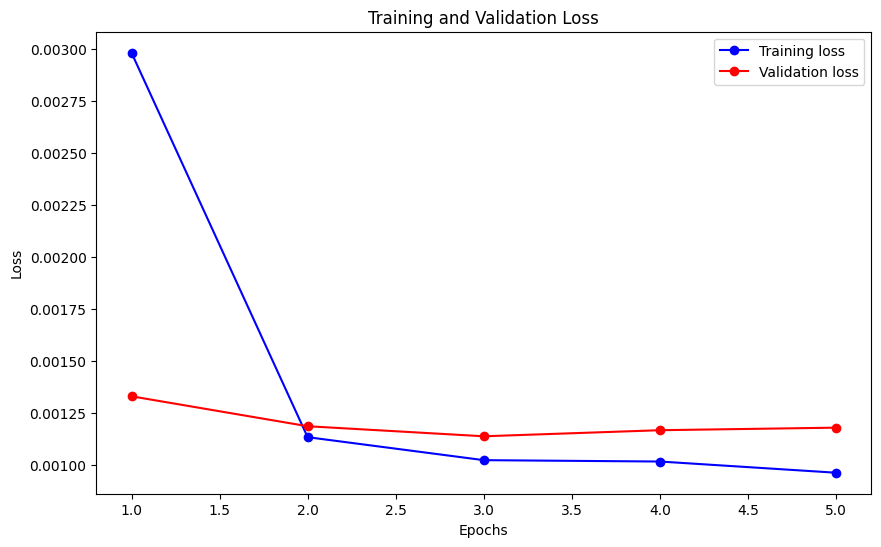

29/29 [==============================] - 2s 7ms/step


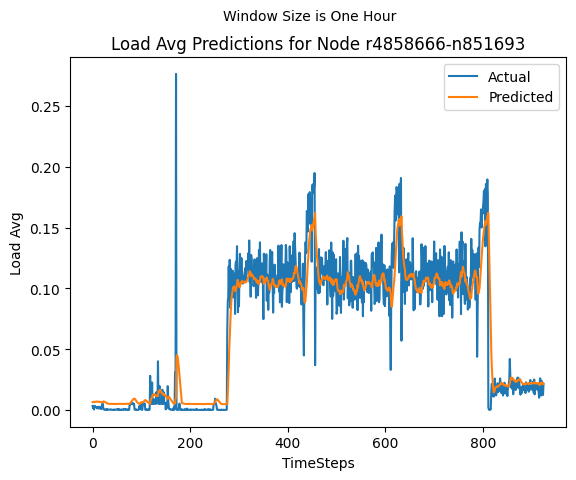

Mean Squared Error (MSE): 0.00048325311600986974
Mean Absolute Error (MAE): 0.01326731471437627
Root Mean Squared Error (RMSE): 0.021983018810205975
Median Absolute Error: 0.007148308287287079


In [ ]:
#for scale node A

#Using data from node A to predict next hour for node A

node_A_values = node_A_set[energy_metrics_cols].values
#IMPORTANT
#we are only using the Load Average values
load_avg_values = node_A_values[:, 0] #LoadAvg col

print(len(load_avg_values))

#scaling

lav_reshape = load_avg_values.reshape(-1,1)

scaler = MinMaxScaler()

scaled_lav = scaler.fit_transform(lav_reshape)

#creating train and test
X_train, y_train, X_test, y_test = get_train_test_sets(scaled_lav, seq_len, train_frac = 0.9)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

#output means (number of seuqences, number of datapoints per sequences, number of feautures)

batch_size = 64

#window size and sequence size match
input_shape_A = (11,1)

model_A = create_model(input_shape_A,10,0.5)

# compile
model_A.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit
history_A = model_A.fit(
    X_train,  # features
    y_train,  #labels
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)



training_loss = history_A.history['loss']
validation_loss = history_A.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# evaluate the model
loss = model_A.evaluate(X_test, y_test)

# make predictions
predictions = model_A.predict(X_test)


# plot actual values
plt.plot(y_test, label='Actual')

# plot predicted values
plt.plot(predictions, label='Predicted')

plt.title('Load Avg Predictions for Node r4858666-n851693')
plt.suptitle('Window Size is One Hour', fontsize=10)
plt.xlabel('TimeSteps')
plt.ylabel('Load Avg')
plt.legend()
plt.show()

# MSE
mse_a = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse_a}")


# MAE
mae_a = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae_a}")

# RMSE
rmse_a = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse_a}")




For the next experiments we are using the dataframe of cleaned_data that come from the top 10 nodes that I previously processed. After scaling we are ready for sequence creation.

In [ ]:
#for scale

#scaling
scaler = MinMaxScaler()


scaled_values = scaler.fit_transform(cleaned_data.values)


scaled_df_10 = pd.DataFrame(scaled_values, index=cleaned_data.index, columns=cleaned_data.columns)

# ready for sequence creation
#print(scaled_df_10.head())

#creating train and test using seq_len 12 from before for one hour
X_10train, y_10train, X_10test, y_10test = get_train_test_sets_mv(scaled_df_10,seq_len,4,0.9)

#print("X_train shape:", X_10train.shape)
#print("y_train shape:", y_10train.shape)
#print("X_test shape:", X_10test.shape)
#print("y_test shape:", y_10test.shape)


##Experiment B

Using data from ten nodes to predict for one node - node r4858666-n851693.

Sequence Length = 12 (one hour)

Prediction Horizon = 5 minutes

Epoch 1/10
177/177 [==============================] - 44s 78ms/step - loss: 0.0038 - val_loss: 8.1152e-04
Epoch 2/10
177/177 [==============================] - 5s 26ms/step - loss: 0.0017 - val_loss: 7.9534e-04
Epoch 3/10
177/177 [==============================] - 7s 40ms/step - loss: 0.0012 - val_loss: 7.2158e-04
Epoch 4/10
177/177 [==============================] - 4s 24ms/step - loss: 9.3386e-04 - val_loss: 7.0830e-04
Epoch 5/10
177/177 [==============================] - 5s 28ms/step - loss: 8.2479e-04 - val_loss: 6.7598e-04
Epoch 6/10
177/177 [==============================] - 10s 55ms/step - loss: 8.4317e-04 - val_loss: 6.8470e-04
Epoch 7/10
177/177 [==============================] - 7s 38ms/step - loss: 7.3928e-04 - val_loss: 6.5947e-04
Epoch 8/10
177/177 [==============================] - 5s 29ms/step - loss: 7.3978e-04 - val_loss: 6.6591e-04
Epoch 9/10
177/177 [==============================] - 6s 34ms/step - loss: 7.3403e-04 - val_loss: 6.6775e-04


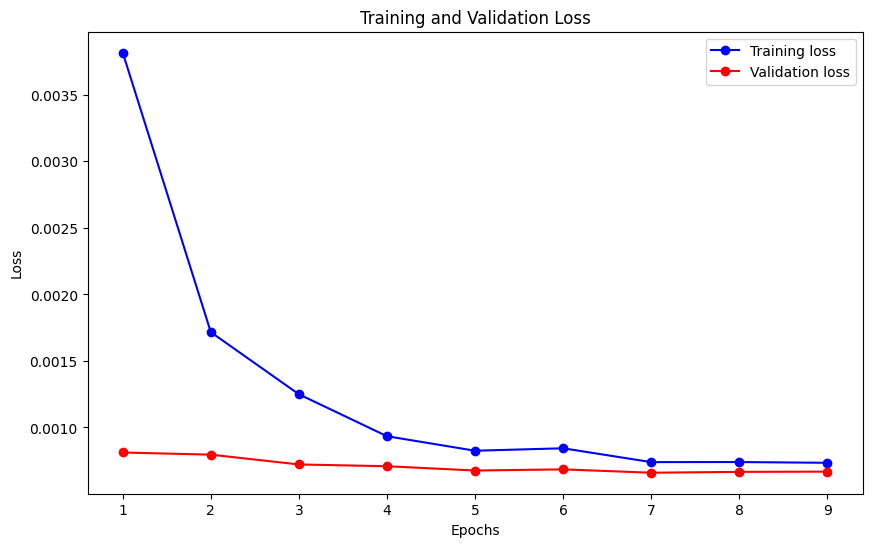

50/50 [==============================] - 2s 7ms/step


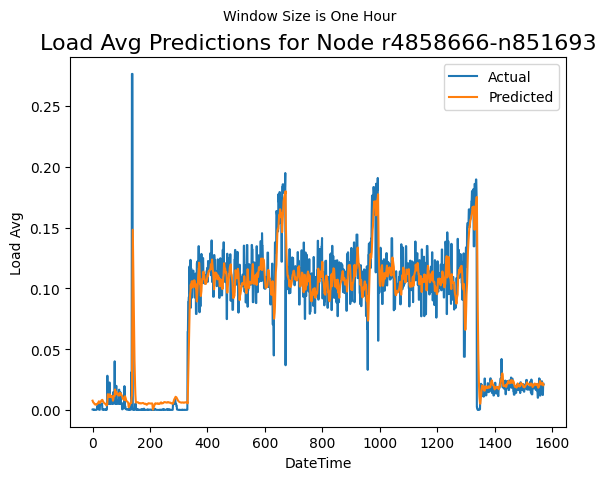

Mean Squared Error (MSE): 0.00042443885982552444
Mean Absolute Error (MAE): 0.012017598782467694
Root Mean Squared Error (RMSE): 0.02060191398451912
Median Absolute Error: 0.006964848376810551


In [ ]:


#output means (number of seuqences, number of datapoints per sequences, number of feautures)

batch_size = 64


#for this test input shape is windowsize = 11,10 because we using ten load avg collums from ten nodes.

input_shape_B = (11,10)

model_B= create_model(input_shape_B,11,0.5)



# compile the model
model_B.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit the model
history = model_B.fit(
    X_10train,
    y_10train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)



training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# evaluate the model
loss = model_B.evaluate(X_10test, y_10test)

# make predictions
predictions = model_B.predict(X_10test)


# plot actual values
plt.plot(y_10test, label='Actual')

# plot predicted values
plt.plot(predictions, label='Predicted')

plt.title('Load Avg Predictions for Node r4858666-n851693', fontsize=16)
plt.suptitle('Window Size is One Hour', fontsize=10)
plt.xlabel('DateTime')
plt.ylabel('Load Avg')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# calculate MSE
mse_b = mean_squared_error(y_10test, predictions)
print(f"Mean Squared Error (MSE): {mse_b}")

# calculate MAE
mae_b = mean_absolute_error(y_10test, predictions)
print(f"Mean Absolute Error (MAE): {mae_b}")

# calculate RMSE
rmse_b = np.sqrt(mean_squared_error(y_10test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse_b}")


In [ ]:



mse_vals = [mse_a, mse_b]
mae_vals = [mae_a, mae_b]
rmse_vals = [rmse_a, rmse_b]
models = ['Uni', 'Multi']

# calculating diffs
mse_diff = abs(mse_vals[0] - mse_vals[1])
mae_diff = abs(mae_vals[0] - mae_vals[1])
rmse_diff = abs(rmse_vals[0] - rmse_vals[1])


a_b = {
    'Metric': ['MSE', 'MAE', 'RMSE'],
    models[0]: [mse_vals[0], mae_vals[0], rmse_vals[0]],
    models[1]: [mse_vals[1], mae_vals[1], rmse_vals[1]],
    'Difference': [mse_diff, mae_diff, rmse_diff]
}

a_vs_b = pd.DataFrame(a_b)
a_vs_b


,Metric,Uni,Multi,Difference
0,MSE,0.000483,0.000424,0.000059
1,MAE,0.013267,0.012018,0.001250
2,RMSE,0.021983,0.020602,0.001381


##Experiment C

Sequence length = 72 (6 hours)

Prediction horizon = 5 minutes

X_train shape: (14076, 71, 10)
y_train shape: (14076,)
X_test shape: (1565, 71, 10)
y_test shape: (1565,)
Epoch 1/10
176/176 [==============================] - 160s 834ms/step - loss: 0.0028 - val_loss: 8.7525e-04
Epoch 2/10
176/176 [==============================] - 134s 759ms/step - loss: 0.0017 - val_loss: 7.2189e-04
Epoch 3/10
176/176 [==============================] - 144s 820ms/step - loss: 0.0010 - val_loss: 6.7221e-04
Epoch 4/10
176/176 [==============================] - 143s 811ms/step - loss: 0.0010 - val_loss: 7.6860e-04
Epoch 5/10
176/176 [==============================] - 142s 808ms/step - loss: 8.0439e-04 - val_loss: 6.7273e-04


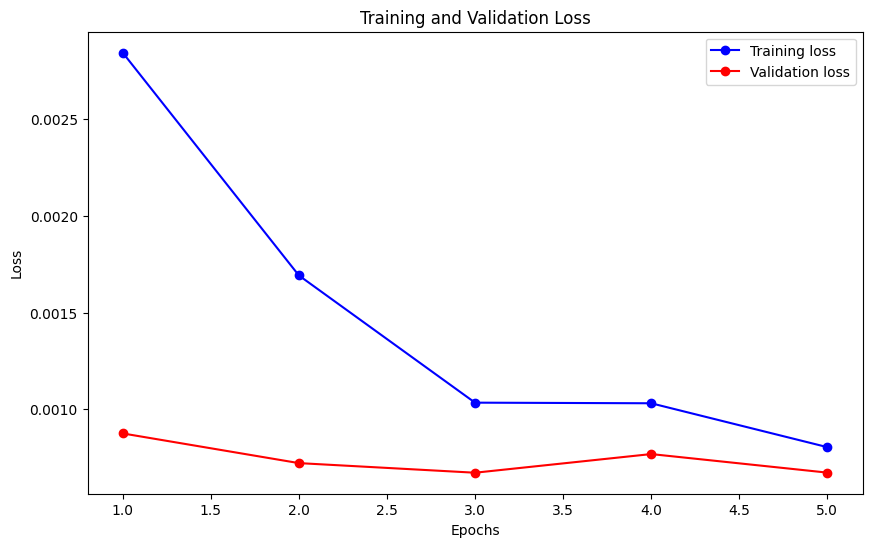

49/49 [==============================] - 9s 127ms/step


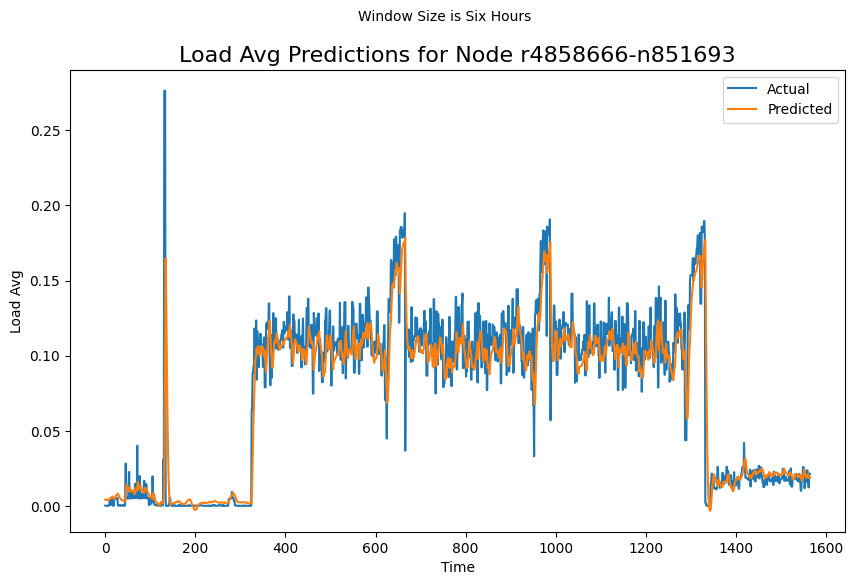

Mean Squared Error (MSE): 0.00043078814926916597
Mean Absolute Error (MAE): 0.011886906933417705
Root Mean Squared Error (RMSE): 0.020755436619574304
Median Absolute Error: 0.007243233569045562


In [ ]:
#for scale

#scaling
scaler = MinMaxScaler()

seq_len_C = 72 #a

scaled_values = scaler.fit_transform(cleaned_data.values)


scaled_df_10 = pd.DataFrame(scaled_values, index=cleaned_data.index, columns=cleaned_data.columns)

# ready for sequence creation
#print(scaled_df_10.head())

#creating train and test
X_10train, y_10train, X_10test, y_10test = get_train_test_sets_mv(scaled_df_10,seq_len_C,4,0.9)

print("X_train shape:", X_10train.shape)
print("y_train shape:", y_10train.shape)
print("X_test shape:", X_10test.shape)
print("y_test shape:", y_10test.shape)


#output means (number of seuqences, number of datapoints per sequences, number of feautures)

batch_size = 64
input_shape_C = (71,10)

model_C= create_model(input_shape_C,71,0.5)


# compile the model
model_C.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit the model
history = model_C.fit(
    X_10train,  # features
    y_10train,  # labels
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)



training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# evaluate the model
loss = model_C.evaluate(X_10test, y_10test)

# make predictions
predictions = model_C.predict(X_10test)

plt.figure(figsize=(10, 6))
# plot actual values
plt.plot(y_10test, label='Actual')
# plot predicted values
plt.plot(predictions, label='Predicted')
plt.title('Load Avg Predictions for Node r4858666-n851693', fontsize=16)
plt.suptitle('Window Size is Six Hours', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Load Avg')
plt.legend()
plt.show()



# calculate MSE
mse_c = mean_squared_error(y_10test, predictions)
print(f"Mean Squared Error (MSE): {mse_c}")



# calculate MAE
mae_c = mean_absolute_error(y_10test, predictions)
print(f"Mean Absolute Error (MAE): {mae_c}")

# calculate RMSE
rmse_c = np.sqrt(mean_squared_error(y_10test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse_c}")



##Experiment D

Sequence Length = 3(15 minutes)

Prediction Horizon = 5 minutes

X_train shape: (14139, 2, 10)
y_train shape: (14139,)
X_test shape: (1571, 2, 10)
y_test shape: (1571,)
Epoch 1/10
177/177 [==============================] - 18s 30ms/step - loss: 0.0080 - val_loss: 0.0032
Epoch 2/10
177/177 [==============================] - 2s 9ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 3/10
177/177 [==============================] - 2s 9ms/step - loss: 0.0067 - val_loss: 0.0031
Epoch 4/10
177/177 [==============================] - 2s 9ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 5/10
177/177 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 6/10
177/177 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 7/10
177/177 [==============================] - 3s 16ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 8/10
177/177 [==============================] - 3s 17ms/step - loss: 0.0024 - val_loss: 9.7736e-04
Epoch 9/10
177/177 [==============================] - 2s 10ms/step - loss: 0.0020 - val

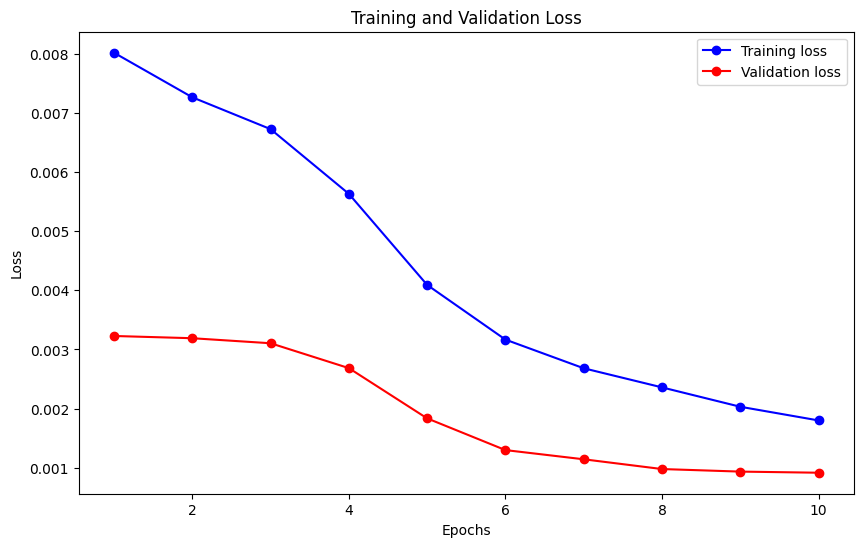

50/50 [==============================] - 3s 4ms/step


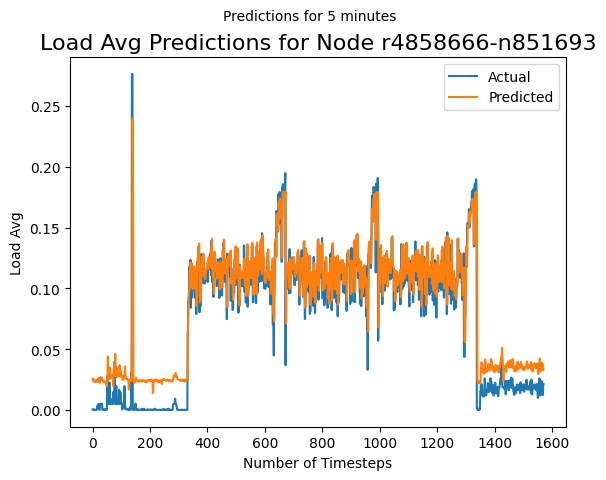

Mean Squared Error (MSE): 0.0005416206152124303
Mean Absolute Error (MAE): 0.017241289793374116
Root Mean Squared Error (RMSE): 0.023272744041312153
Median Absolute Error: 0.01677455104790726


In [ ]:
#for scale

#scaling
scaler = MinMaxScaler()

seq_len_D = 3 # 15 minute windows

scaled_values = scaler.fit_transform(cleaned_data.values)


scaled_df_10 = pd.DataFrame(scaled_values, index=cleaned_data.index, columns=cleaned_data.columns)

# ready for sequence creation
#print(scaled_df_10.head())

#creating train and test
X_10train, y_10train, X_10test, y_10test = get_train_test_sets_mv(scaled_df_10,seq_len_D,4,0.9)

print("X_train shape:", X_10train.shape)
print("y_train shape:", y_10train.shape)
print("X_test shape:", X_10test.shape)
print("y_test shape:", y_10test.shape)


#output means (number of seuqences, number of datapoints per sequences, number of feautures)

batch_size = 64
input_shape_D = (2,10)

model_D= create_model(input_shape_D,2,0.5)


# compile the model
model_D.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit the model
history = model_D.fit(
    X_10train,  # Training features
    y_10train,  # Training labels
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)



training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# evaluate the model
loss = model_D.evaluate(X_10test, y_10test)

# make predictions
predictions = model_D.predict(X_10test)


# plot actual values
plt.plot(y_10test, label='Actual')

# plot predicted values
plt.plot(predictions, label='Predicted')


plt.title('Load Avg Predictions for Node r4858666-n851693', fontsize=16)
plt.suptitle('Predictions for 5 minutes', fontsize=10)
plt.xlabel('Number of Timesteps')
plt.ylabel('Load Avg')
plt.legend()
plt.show()


# calculate MSE
mse_d = mean_squared_error(y_10test, predictions)
print(f"Mean Squared Error (MSE): {mse_d}")

# calculate MAE
mae_d = mean_absolute_error(y_10test, predictions)
print(f"Mean Absolute Error (MAE): {mae_d}")

# calculate RMSE
rmse_d = np.sqrt(mean_squared_error(y_10test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse_d}")

# calculate Median Absolute Error
med_ae_d = median_absolute_error(y_10test, predictions)
print(f"Median Absolute Error: {med_ae_d}")


In [ ]:
mse_vals = [mse_b, mse_c,mse_d]
mae_vals = [mae_b, mae_c,mae_d]
rmse_vals = [rmse_b, rmse_c,rmse_d]
models = ['Seq Length=12', 'Seq Length = 72','Seq Length = 3']


b_to_d = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE'],
    models[0]: [mse_vals[0], mae_vals[0], rmse_vals[0]],
    models[1]: [mse_vals[1], mae_vals[1], rmse_vals[1]],
    models[2]: [mse_vals[2], mae_vals[2], rmse_vals[2]],
})

b_to_d

,Metric,Seq Length=12,Seq Length = 72,Seq Length = 3
0,MSE,0.000424,0.000431,0.000542
1,MAE,0.012018,0.011887,0.017241
2,RMSE,0.020602,0.020755,0.023273


In [ ]:
def get_train_test_sets_mv_one_hour_ahead(data, seq_len, target_node_index, train_frac, forecast_horizon=12):

    #sequences need to be sequnce length plus prediction horizon to include what we want to predict

    sequences = split_into_sequences(data, seq_len + forecast_horizon - 1)
    #here we seperate the input sequence length and the steps we want to predict as labels
    X = sequences[:, :seq_len, :]
    #the label is always one hour ahead of the input sequence
    y = sequences[:, forecast_horizon - 1:, target_node_index]
    y = y[:, -1]  # take the last value as the label for each sequence

    n_train = int(len(X) * train_frac)
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    #getting labels still from target node and setting labels to be ahead

    return X_train, y_train, X_test, y_test

    #so if desired sequence length is 12 and prediction length is also 12 then sequnces are
    #length 24(including zero) and then seperated into input and labels.


##Experiment E

Sequence Length = 3 (15 minutes)

Prediction Horizon = 12 (one hour)

using 15 mins of ten node data to predict an hour

X_train shape: (14129, 3, 10)
y_train shape: (14129,)
X_test shape: (1570, 3, 10)
y_test shape: (1570,)
Epoch 1/10
177/177 [==============================] - 19s 33ms/step - loss: 0.0075 - val_loss: 0.0028
Epoch 2/10
177/177 [==============================] - 4s 20ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 3/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 4/10
177/177 [==============================] - 2s 11ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 5/10
177/177 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/10
177/177 [==============================] - 2s 10ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 7/10
177/177 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/10
177/177 [==============================] - 3s 19ms/step - loss: 0.0023 - val_loss: 0.0017


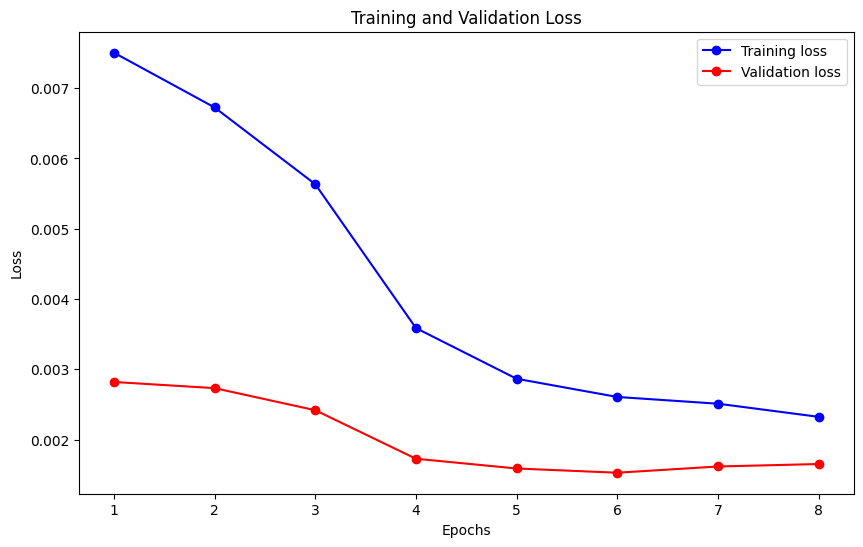

50/50 [==============================] - 2s 3ms/step


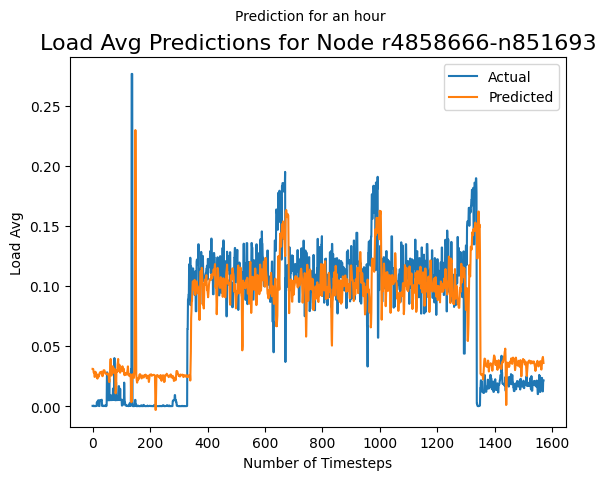

Mean Squared Error (MSE): 0.001044664388408101
Mean Absolute Error (MAE): 0.023109309032389946
Root Mean Squared Error (RMSE): 0.023272744041312153
Median Absolute Error: 0.02062523641522031


In [ ]:
#for scale

#scaling
scaler = MinMaxScaler()

seq_len_E = 3 # 15 minute windows

scaled_values = scaler.fit_transform(cleaned_data.values)
#print(cleaned_data.head())


scaled_df_10 = pd.DataFrame(scaled_values, index=cleaned_data.index, columns=cleaned_data.columns)

# ready for sequence creation
#print(scaled_df_10.head())

#creating train and test
X_10train, y_10train, X_10test, y_10test = get_train_test_sets_mv_one_hour_ahead(scaled_df_10,seq_len_E,4,0.9)

print("X_train shape:", X_10train.shape)
print("y_train shape:", y_10train.shape)
print("X_test shape:", X_10test.shape)
print("y_test shape:", y_10test.shape)


#output means (number of seuqences, number of datapoints per sequences, number of feautures)

batch_size = 64
input_shape_E = (2,10)

model_E= create_model(input_shape_E,2,0.5)


model_E.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fittt
history = model_E.fit(
    X_10train,  # Training features
    y_10train,  # Training labels
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)



training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)
dates = scaled_df_10.index[-len(predictions):]
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# model eval
loss = model_E.evaluate(X_10test, y_10test)

# make predictions
predictions = model_E.predict(X_10test)


# plot actual values
plt.plot(y_10test,label='Actual')

# plot predicted values
plt.plot(predictions, label='Predicted')

plt.title('Load Avg Predictions for Node r4858666-n851693', fontsize=16)
plt.suptitle('Prediction for an hour', fontsize=10)
plt.xlabel('Number of Timesteps')
plt.ylabel('Load Avg')
plt.legend()
plt.show()

# cal MSE
mse_e = mean_squared_error(y_10test, predictions)
print(f"Mean Squared Error (MSE): {mse_e}")



# cal MAE
mae_e = mean_absolute_error(y_10test, predictions)
print(f"Mean Absolute Error (MAE): {mae_e}")

# RMSE
rmse_e = np.sqrt(mean_squared_error(y_10test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse_d}")



In [ ]:
def get_train_test_sets_mv_one_day_ahead(data, seq_len, target_node_index, train_frac, forecast_horizon=288):

    sequences = split_into_sequences(data, seq_len + forecast_horizon - 1)

    X = sequences[:, :seq_len, :]
    y = sequences[:, forecast_horizon - 1:, target_node_index]
    y = y[:, -1]  # last value as the label for each sequence

    n_train = int(len(X) * train_frac)
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, y_train, X_test, y_test


##Experiment F:

Sequence Length = 12 (1hr)

Prediction Horizon = 288 (24 hours)

using three hours to predict for whole day

X_train shape: (14110, 12, 10)
y_train shape: (14110,)
X_test shape: (1568, 12, 10)
y_test shape: (1568,)
Epoch 1/10
177/177 [==============================] - 23s 56ms/step - loss: 0.0201 - val_loss: 0.0083
Epoch 2/10
177/177 [==============================] - 5s 27ms/step - loss: 0.0120 - val_loss: 0.0080
Epoch 3/10
177/177 [==============================] - 7s 41ms/step - loss: 0.0114 - val_loss: 0.0082
Epoch 4/10
177/177 [==============================] - 8s 47ms/step - loss: 0.0110 - val_loss: 0.0086


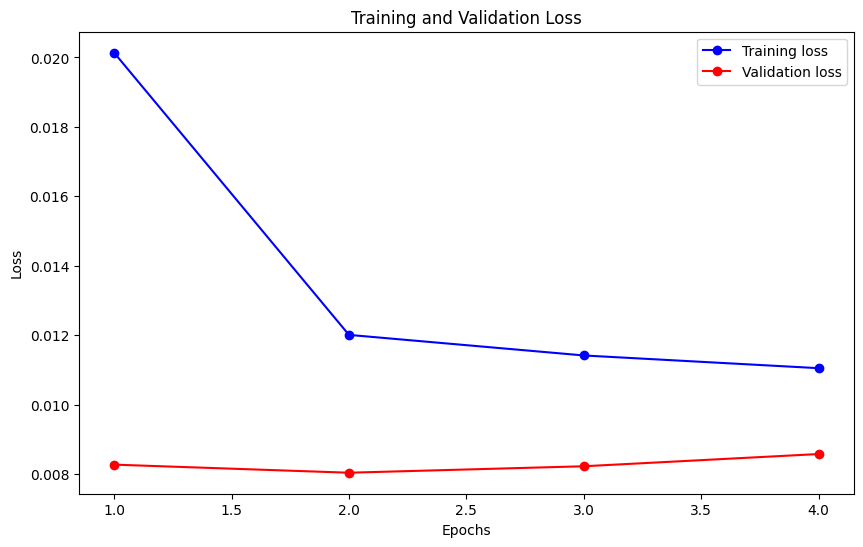

49/49 [==============================] - 3s 7ms/step


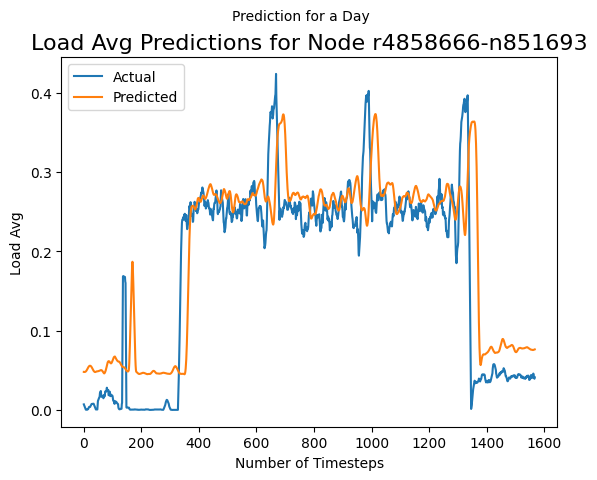

Mean Squared Error (MSE): 0.004702503337383161
Mean Absolute Error (MAE): 0.044964439847513894
Root Mean Squared Error (RMSE): 0.06857480103786784
Median Absolute Error: 0.034105825486911184


In [ ]:
#for scale

#poor results so rolling averages had to be considered.

#now each data point is hourly data averages for that window:)
rolling_avg_data = cleaned_data.rolling(window=12, min_periods=1).mean()

rolling_avg_data.fillna(method='ffill', inplace=True)
rolling_avg_data.fillna(method='bfill', inplace=True)

#scaling
scaler = MinMaxScaler()

seq_len_F = 12 # 15 Sequence Length

scaled_values = scaler.fit_transform(rolling_avg_data.values)


scaled_df_10 = pd.DataFrame(scaled_values, index=rolling_avg_data.index, columns=rolling_avg_data.columns)

# ready for sequence creation
#print(scaled_df_10.head())

#creating train and test
X_10train_f, y_10train_f, X_10test_f, y_10test_f = get_train_test_sets_mv_one_day_ahead(scaled_df_10,seq_len_F,4,0.9)

##output means (number of seuqences, number of datapoints per sequences, number of feautures)
print("X_train shape:", X_10train_f.shape)
print("y_train shape:", y_10train_f.shape)
print("X_test shape:", X_10test_f.shape)
print("y_test shape:", y_10test_f.shape)
#rolling avergaes dont reduce number of datapoints just smoothes the values

#output means (number of seuqences, number of datapoints per sequences, number of feautures)

batch_size = 64
input_shape_F = (11,10)

model_F= create_model(input_shape_F,11,0.5)


# compile the model
model_F.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit the model
history = model_F.fit(
    X_10train_f,  #features
    y_10train_f,  #labels
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)



training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# eval the model
loss = model_F.evaluate(X_10test_f, y_10test_f)

# predictions
predictions_f = model_F.predict(X_10test_f)


#actual values
plt.plot(y_10test_f, label='Actual')

# predicted values
plt.plot(predictions_f, label='Predicted')


plt.title('Load Avg Predictions for Node r4858666-n851693', fontsize=16)
plt.suptitle('Prediction for a Day', fontsize=10)
plt.xlabel('Number of Timesteps')
plt.ylabel('Load Avg')
plt.legend()
plt.show()


# calculate MSE
mse_f = mean_squared_error(y_10test_f, predictions_f)
print(f"Mean Squared Error (MSE): {mse_f}")



# calculate MAE
mae_f = mean_absolute_error(y_10test_f, predictions_f)
print(f"Mean Absolute Error (MAE): {mae_f}")

# calculate RMSE
rmse_f = np.sqrt(mean_squared_error(y_10test_f, predictions_f))
print(f"Root Mean Squared Error (RMSE): {rmse_f}")



In [ ]:

mse_vals = [mse_e, mse_f]
mae_vals = [mae_e, mae_f]
rmse_vals = [rmse_e, rmse_f]
models = ['One Hour Ahead', 'One Day Ahead']

# calculating diffs
mse_diff = abs(mse_vals[0] - mse_vals[1])
mae_diff = abs(mae_vals[0] - mae_vals[1])
rmse_diff = abs(rmse_vals[0] - rmse_vals[1])


e_f = {
    'Metric': ['MSE', 'MAE', 'RMSE'],
    models[0]: [mse_vals[0], mae_vals[0], rmse_vals[0]],
    models[1]: [mse_vals[1], mae_vals[1], rmse_vals[1]],
    'Difference': [mse_diff, mae_diff, rmse_diff]
}

e_vs_f = pd.DataFrame(e_f)
e_vs_f

,Metric,One Hour Ahead,One Day Ahead,Difference
0,MSE,0.001045,0.004703,0.003658
1,MAE,0.023109,0.044964,0.021855
2,RMSE,0.032321,0.068575,0.036254


In [ ]:
def get_train_test_sets_mv_one_week(data, seq_len, target_node_index, train_frac, forecast_horizon=168):

    sequences = split_into_sequences(data, seq_len + forecast_horizon - 1)

    X = sequences[:, :seq_len, :]
    y = sequences[:, forecast_horizon - 1:, target_node_index]
    y = y[:, -1]  #last value as the label for each sequence

    n_train = int(len(X) * train_frac)
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, y_train, X_test, y_test
